***
## Table of Contents
<br>
    <ol><h2><a href='#0' style="text-decoration : none; color : #000000;">1. Loading and Cleaning Data </a></h2> </ol>
    <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">2. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">3. Feature Transformation with feature selection </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">4. Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">5.Over Sampling</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">6.Under Sampling</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
    

In [39]:
import pandas as pd
import numpy as np
import os
import json
from pandas.io.json import json_normalize
from IPython.display import display,clear_output,HTML
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

import copy

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression,RandomizedLasso,LinearRegression, Ridge,Lasso
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split,cross_val_score

from sklearn.preprocessing import MinMaxScaler,StandardScaler,binarize
from sklearn.ensemble import RandomForestRegressor
# from minepy import MINE
from sklearn import metrics

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score
from sklearn import metrics
from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
#     m['Features']=m['Features'].str.replace("dom_function_","")
#     m['Features']=m['Features'].str.replace("js_function_","")
#     m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
#     m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [3]:
def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)
    
    y_pred_train=knn.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the KNN model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=knn.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the KNN model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return knn,cm_train,cm_test,acc_train,acc_test,roc_auc

In [4]:
def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    y_pred_train=log.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Logistic Regression model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=log.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Logistic Regression model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return log,cm_train,cm_test,acc_train,acc_test,roc_auc

In [5]:
def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)
    
    y_pred_train=rf.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Random Forest Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=rf.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Random Forest Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(rf.feature_importances_,feat)
    return rf,cm_train,cm_test,acc_train,acc_test,roc_auc,rf.feature_importances_

In [6]:
def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    y_pred_train=ada.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Ada Boost Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ada.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Ada Boost Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ada.feature_importances_,feat)
    return ada,cm_train,cm_test,acc_train,acc_test,roc_auc,ada.feature_importances_

In [7]:
def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    y_pred_train=gbc.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Gradient Boosting Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=gbc.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Gradient Boosting Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(gbc.feature_importances_,feat)
    return gbc,cm_train,cm_test,acc_train,acc_test,roc_auc,gbc.feature_importances_

In [8]:
def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    y_pred_train=ext_tree.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Extra Tree Classifier model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=ext_tree.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Extra Tree Classifier for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    feat_impt_plot(ext_tree.feature_importances_,feat)
    return ext_tree,cm_train,cm_test,acc_train,acc_test,roc_auc,ext_tree.feature_importances_

In [9]:
def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    y_pred_train=bagging.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    print("Accuracy of the Bagging model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=bagging.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the Bagging model for twst data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    
    return bagging,cm_train,cm_test,acc_train,acc_test,roc_auc

In [10]:
def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc

### <a id='0' style="text-decoration : none; color : #000000;"> 1. Loading and Cleaning Data</a>

In [11]:
df_html=pd.read_csv('HTML.csv',index_col='domain')
df_html.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df_html.columns if 'number' in col]
df_html.drop(cookie,axis=1,inplace=True)
print("Shape of our dataset:",df_html.shape)

df_html.head()

Shape of our dataset: (43491, 1461)


,a_charset_utf-8,a_count,a_download_download,a_hidden_true,a_href_.7z,a_href_.apk,a_href_.app,a_href_.asp,a_href_.aspx,a_href_.au,a_href_.avi,a_href_.b,a_href_.bin,a_href_.br,a_href_.bz2,a_href_.ca,a_href_.cat,a_href_.cc,a_href_.cfm,a_href_.cgi,a_href_.ch,a_href_.chn,a_href_.cl,a_href_.cms,a_href_.com,a_href_.csp,a_href_.css,a_href_.data,a_href_.de,a_href_.dmg,a_href_.do,a_href_.doc,a_href_.docx,a_href_.dot,a_href_.dz,a_href_.end,a_href_.exe,a_href_.fx,a_href_.gif,a_href_.gsp,a_href_.gz,a_href_.htm,a_href_.html,a_href_.i,a_href_.id,a_href_.io,a_href_.iso,a_href_.it,a_href_.jhtml,a_href_.jpeg,a_href_.jpg,a_href_.js,a_href_.jsf,a_href_.json,a_href_.jsp,a_href_.lnk,a_href_.m3u,a_href_.md,a_href_.me,a_href_.mhp,a_href_.mp3,a_href_.mp4,a_href_.mpl,a_href_.mvc,a_href_.net,a_href_.ogg,a_href_.org,a_href_.pcf,a_href_.pd,a_href_.pdf,a_href_.php,a_href_.phtml,a_href_.pk,a_href_.pl,a_href_.pls,a_href_.png,a_href_.prd,a_href_.pro,a_href_.rar,a_href_.rdf,a_href_.rf,a_href_.rss,a_href_.ru,a_href_.shtml,a_href_.spa,a_href_.svg,a_href_.swf,a_href_.tag,a_href_.tmpl,a_href_.tr,a_href_.tsp,a_href_.tv,a_href_.txt,a_href_.vid,a_href_.wml,a_href_.wmv,a_href_.x,a_href_.xhtml,a_href_.xls,a_href_.xlsx,a_href_.xml,a_href_.xxx,a_href_.xyz,a_href_.xz,a_href_.zip,a_href_0,a_href_0.1,a_href_0.2,a_href_absolute,a_href_ftp,a_href_http,a_href_https,a_href_irc,a_href_mailto,a_href_out_of_domain,a_href_relative,a_href_script_javascript,a_hreflang_am,a_hreflang_ar,a_hreflang_az,a_hreflang_bs,a_hreflang_ca,a_hreflang_cs,a_hreflang_de,a_hreflang_el,a_hreflang_en,a_hreflang_en-gb,a_hreflang_en-us,a_hreflang_es,a_hreflang_es-ES,a_hreflang_fi,a_hreflang_fr,a_hreflang_hu,a_hreflang_id,a_hreflang_it,a_hreflang_ja,a_hreflang_ko,a_hreflang_ml,a_hreflang_nl,a_hreflang_no,a_hreflang_pl,a_hreflang_pt,a_hreflang_pt-br,a_hreflang_ro,a_hreflang_ru,a_hreflang_sv,a_hreflang_tr,a_hreflang_und,a_hreflang_zh,a_hreflang_zh-hans,a_hreflang_zxx,a_lang_a1,a_lang_ar,a_lang_bg,a_lang_ca,a_lang_cs,a_lang_da,a_lang_de,a_lang_el,a_lang_en,a_lang_en-GB,a_lang_en-US,a_lang_es,a_lang_es-ES,a_lang_fi,a_lang_fr,a_lang_he,a_lang_hi,a_lang_hr,a_lang_hu,a_lang_id,a_lang_it,a_lang_ja,a_lang_ko,a_lang_nl,a_lang_pl,a_lang_pt,a_lang_ro,a_lang_ru,a_lang_sk,a_lang_sv,a_lang_th,a_lang_tr,a_lang_vi,a_lang_zh,a_referrerpolicy_unsafe-url,a_rel_ nofollow,a_rel_ noopener,a_rel_ noopener noreferrer,a_rel_ noreferrer noopener,"a_rel_""nofollow""",a_rel_#modal-overlay,a_rel_#modalExternalSiteCluetip,a_rel_#selectFiliale,a_rel_'nofollow',a_rel_0,a_rel_1,a_rel_10,a_rel_11,a_rel_12,a_rel_13,a_rel_14,a_rel_15,a_rel_16,a_rel_17,a_rel_2,a_rel_3,a_rel_4,a_rel_5,a_rel_6,a_rel_7,a_rel_8,a_rel_9,a_rel_<strong>@font-face Embedding</strong> - this free license allows you to embed the font in your websites with CSS.,a_rel_<strong>Commercial Desktop Use</strong> - this free license allows you to create commercial graphics and documents.,a_rel_Akamai-prefetch,a_rel_Dofollow,a_rel_F,a_rel_Lightbox,a_rel_Menu,a_rel_NOFOLLOW,a_rel__blank,a_rel_about,a_rel_accounts,a_rel_ajaxcontentarea,a_rel_alternate,a_rel_alternate noopener noreferrer,a_rel_archive,a_rel_article,a_rel_attachment,a_rel_author,a_rel_author external,a_rel_author source external,a_rel_blank,a_rel_bookmark,a_rel_bookmark noopener,a_rel_box,a_rel_canonical,a_rel_category,a_rel_category tag,a_rel_category tag noopener noreferrer,a_rel_chapter,a_rel_chartPopup nofollow,a_rel_cklog,a_rel_contact,a_rel_contents,a_rel_countrycontainer,a_rel_date,a_rel_ddsubmenuside1,a_rel_default,...,object_data_http,object_data_https,object_data_out_of_domain,object_data_relative,object_style_display: block; position: absolute; top: 0px; left: 0px; height: 100%; width: 100%; overflow: hidden; pointer-events: none; z-index: -1;,object_style_display: none;,object_type_application/x-shockwave-flash,object_type_image/svg+xml,object_type_text/html,ol_count,optgroup_count,option_count,output_count,p_count,param_count,picture_count,pre_count,progress_count,q_count,s_count,samp_count,script_async

In [12]:
df_js=pd.read_csv('Javascript.csv',low_memory=False,index_col='domain')

cookie=[col for col in df_js.columns if 'functions' in col]

df_js.rename(columns={'Malicious':'Target'},inplace=True)

df_js.drop(['number_functions_declared'],axis=1,inplace=True)

print("Shape of our dataset:",df_js.shape)

df_js.head()

Shape of our dataset: (43294, 406)


,dom_function_document.adoptNode(,dom_function_document.captureEvents(,dom_function_document.caretPositionFromPoint(,dom_function_document.caretRangeFromPoint(,dom_function_document.clear(,dom_function_document.close(,dom_function_document.createAttribute(,dom_function_document.createAttributeNS(,dom_function_document.createCDATASection(,dom_function_document.createComment(,dom_function_document.createDocumentFragment(,dom_function_document.createElement(,dom_function_document.createElementNS(,dom_function_document.createEntityReference(,dom_function_document.createEvent(,dom_function_document.createNodeIterator(,dom_function_document.createProcessingInstruction(,dom_function_document.createRange(,dom_function_document.createTextNode(,dom_function_document.createTouch(,dom_function_document.createTouchList(,dom_function_document.createTreeWalker(,dom_function_document.elementFromPoint(,dom_function_document.elementsFromPoint(,dom_function_document.enableStyleSheetsForSet(,dom_function_document.execCommand(,dom_function_document.exitPointerLock(,dom_function_document.getAnimations(,dom_function_document.getElementById(,dom_function_document.getElementByName(,dom_function_document.getElementsByClassName(,dom_function_document.getElementsByTagName(,dom_function_document.getElementsByTagNameNS(,dom_function_document.getSelection(,dom_function_document.hasFocus(,dom_function_document.importNode(,dom_function_document.normalizeDocument(,dom_function_document.open(,dom_function_document.queryCommandEnabled(,dom_function_document.queryCommandIndeterm(,dom_function_document.queryCommandValue(,dom_function_document.querySelector(,dom_function_document.querySelectorAll(,dom_function_document.releaseCapture(,dom_function_document.releaseEvent(,dom_function_document.routeEvent(,dom_function_document.write(,dom_function_document.writeln(,dom_function_window.addEventListener(,dom_function_window.alert(,dom_function_window.atob(,dom_function_window.back(,dom_function_window.blur(,dom_function_window.btoa(,dom_function_window.cancelAnimationFrame(,dom_function_window.cancelIdleCallback(,dom_function_window.captureEvents(,dom_function_window.clearImmediate(,dom_function_window.clearInterval(,dom_function_window.clearTimeout(,dom_function_window.close(,dom_function_window.confirm(,dom_function_window.createImageBitmap(,dom_function_window.disableExternalCapture(,dom_function_window.dispatchEvent(,dom_function_window.dump(,dom_function_window.enableExternalCapture(,dom_function_window.fetch(,dom_function_window.find(,dom_function_window.focus(,dom_function_window.forward(,dom_function_window.getAttention(,dom_function_window.getAttentionWithCycleCount(,dom_function_window.getComputedStyle(,dom_function_window.getDefaultComputedSyle(,dom_function_window.getSelection(,dom_function_window.home(,dom_function_window.matchMedia(,dom_function_window.maximize(,dom_function_window.minimize(,dom_function_window.moveBy(,dom_function_window.moveTo(,dom_function_window.open(,dom_function_window.openDialog(,dom_function_window.postMessage(,dom_function_window.print(,dom_function_window.prompt(,dom_function_window.releaseEvents(,dom_function_window.removeEventListener(,dom_function_window.requestAnimationFrame(,dom_function_window.requestIdleCallback(,dom_function_window.resizeBy(,dom_function_window.resizeTo(,dom_function_window.restore(,dom_function_window.routeEvent(,dom_function_window.scroll(,dom_function_window.scrollBy(,dom_function_window.scrollByLines(,dom_function_window.scrollByPages(,dom_function_window.scrollTo(,dom_function_window.setCursor(,dom_function_window.setImmediate(,dom_function_window.setInterval(,dom_function_window.setResizable(,dom_function_window.setTimeout(,dom_function_window.sizeToContent(,dom_function_window.stop(,dom_function_window.updateCommands(,js_function_.add(,js_function_.all(,js_function_.allTrue(,js_function_.anchor(,js_function_.apply(,js_function_.big(,js_function_.bind(,js_function_.blink(,js_function_.bold(,js_funct

In [13]:
col_js_no_uni=remove_feat(df_js)
col_html_no_uni=remove_feat(df_html)

In [14]:
print("{} columns in JavaScript experiment with all missing or only one unique value".format(len(col_js_no_uni)))
print("{} columns in HTML experiment with all missing or only one unique value".format(len(col_html_no_uni)))

113 columns in JavaScript experiment with all missing or only one unique value
0 columns in HTML experiment with all missing or only one unique value


In [15]:
df_js.drop(col_js_no_uni,axis=1,inplace=True)
df_html.drop(col_html_no_uni,axis=1,inplace=True)

In [16]:
print("Shape of JavaScript experiemtn after dropping them:",df_js.shape)
print("Shape of HTML experiemtn after dropping them:",df_html.shape)

Shape of JavaScript experiemtn after dropping them: (43294, 293)
Shape of HTML experiemtn after dropping them: (43491, 1461)


In [17]:
col_js_95=uni_value(df_js)
col_html_95=uni_value(df_html)
print("{} columns in JavaScript experiment with more than 95% same values".format(len(col_js_95[col_js_95['95_%_same_values']==True])))
print("{} columns in HTML experiment with more than 95% same values".format(len(col_html_95[col_html_95['95_%_same_values']==True])))

234 columns in JavaScript experiment with more than 95% same values
1297 columns in HTML experiment with more than 95% same values


In [18]:
### Lets drop those columns
df_js.drop(col_js_95[col_js_95['95_%_same_values']==True].index.values,axis=1,inplace=True)

df_html.drop(col_html_95[col_html_95['95_%_same_values']==True].index.values,axis=1,inplace=True)

print("Shape of JavaScript experiment after dropping them:",df_js.shape)
print("Shape of HTML experiment after dropping them:",df_html.shape)

Shape of JavaScript experiment after dropping them: (43294, 59)
Shape of HTML experiment after dropping them: (43491, 164)


#### Let us analyze the balance of classes

In [19]:
class_bal(df_js,'JavaScript experiment')
class_bal(df_html,'HTML experiment')

#### Analyzing the categorical and numerical features

In [20]:
cat_var_js,num_var_js=check_cat(df_js)
cat_var_html,num_var_html=check_cat(df_html)

In [21]:
df_js.Target=df_js.Target.apply(lambda x: 1 if x=='Malicious' else 0)
df_html.Target=df_html.Target.apply(lambda x: 1 if x=='Malicious' else 0)

print("Stats for numerical features for JavaScript experiment\n")
num_stats_js=num_stats(df_js,num_var_js)
display(num_stats_js)
print("\nStats for Categorical features for JavaScript experiment\n")
cat_stats_js=cat_stats(df_js,cat_var_js)
display(cat_stats_js)

Stats for numerical features for JavaScript experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
number_of_cookies,-0.349925,0.000000e+00,-152.836194,0.000000e+00
number_of_unsecure_cookies,-0.345278,0.000000e+00,-149.577298,0.000000e+00
number_of_non_http_only_cookies,-0.335473,0.000000e+00,-148.098816,0.000000e+00
dom_function_document.getElementsByTagName(,-0.206833,0.000000e+00,-94.422955,0.000000e+00
number_of_http_only_cookies,-0.191954,0.000000e+00,-78.875103,0.000000e+00
dom_function_document.createElement(,-0.154604,9.233651e-230,-72.422095,0.000000e+00
js_function_.getTime(,-0.149504,8.006211e-215,-70.045384,0.000000e+00
dom_function_window.addEventListener(,-0.107093,1.299881e-110,-51.397683,0.000000e+00
number_of_secure_cookies,-0.111267,2.660489e-119,-48.907941,0.000000e+00



Stats for Categorical features for JavaScript experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,


In [22]:
print("Stats for numerical features for HTML experiment\n")
num_stats_html=num_stats(df_html,num_var_html)
display(num_stats_html)
print("\nStats for Categorical features for HTML experiment\n")
cat_stats_html=cat_stats(df_html,cat_var_html)
display(cat_stats_html)

Stats for numerical features for HTML experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
script_src_.js,-0.319546,0.000000e+00,-142.596194,0.000000e+00
script_count,-0.315619,0.000000e+00,-142.448699,0.000000e+00
script_src_relative,-0.310931,0.000000e+00,-135.577261,0.000000e+00
script_src_absolute,-0.310931,0.000000e+00,-135.577261,0.000000e+00
script_src_https,-0.271077,0.000000e+00,-126.553948,0.000000e+00
script_async_true,-0.245742,0.000000e+00,-118.214320,0.000000e+00
link_rel_canonical,-0.276351,0.000000e+00,-114.117813,0.000000e+00
div_count,-0.231558,0.000000e+00,-113.026088,0.000000e+00
script_type_text/javascript,-0.264055,0.000000e+00,-111.582561,0.000000e+00



Stats for Categorical features for HTML experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,


In [88]:
fin_col=num_stats_js.index.values[0:25].tolist()+cat_stats_js.index.values[0:25].tolist() + num_stats_html.index.values[0:25].tolist()+cat_stats_html.index.values[0:25].tolist() 

#### We can see from the graph that there is high imbalance in the dataset. We can handle it either by oversampling, undersampling or tuning our models to focus on recall/precision to address the problem

#### Cleaning and analyzing the dataset.


#### We know that many of the features will all have no more than one unique value. Hence, we will first identify and drop those features

#### Columns which have do not have any unique values

In [89]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [90]:
print("Features we will be using:")
display(fin_col)

Features we will be using:


['number_of_cookies',
 'number_of_unsecure_cookies',
 'number_of_non_http_only_cookies',
 'dom_function_document.getElementsByTagName(',
 'number_of_http_only_cookies',
 'dom_function_document.createElement(',
 'js_function_.getTime(',
 'dom_function_window.addEventListener(',
 'number_of_secure_cookies',
 'js_function_.split(',
 'js_function_Math.random(',
 'js_function_.setTime(',
 'js_function_.replace(',
 'js_function_.indexOf(',
 'js_function_Math.floor(',
 'js_function_decodeURIComponent(',
 'js_function_.match(',
 'js_function_JSON.parse(',
 'js_function_.pop(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_encodeURIComponent(',
 'js_function_.test(',
 'js_function_.apply(',
 'js_function_.substr',
 'script_src_.js',
 'script_count',
 'script_src_relative',
 'script_src_absolute',
 'script_src_https',
 'script_async_true',
 'link_rel_canonical',
 'div_count',
 'script_type_text/javascript',
 'script_src_out_of_domain',
 'iframe_count',
 'a_count',
 'a_href_rela

In [43]:
df_int=pd.merge(df_js,df_html,left_index=True,right_index=True)

df=df_int.copy(deep=True)

df['Target']=df[['Target_x','Target_y']].apply(max,axis=1)

In [91]:
columns=copy.deepcopy(fin_col)
fin_col.append('Target')

df_sel=df[fin_col]

display(df_sel.shape)

(40709, 51)

In [45]:
class_bal(df_sel,'Combined experiments')

In [46]:
### Preparing our training and test sets
X=df_sel.iloc[:,df_sel.columns!='Target'].values
y=df_sel.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [47]:
f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

In [48]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [49]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.871710627322
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27677   185    27862
True        3993   712     4705
__all__    31670   897    32567

Accuracy of the KNN model for twst data is: 0.864529599607
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6856    60     6916
True        1043   183     1226
__all__     7899   243     8142



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.884054410907
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25019  2843    27862
True         933  3772     4705
__all__    25952  6615    32567

Accuracy of the Logistic Regression model for twst data is: 0.883198231393
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6203   713     6916
True         238   988     1226
__all__     6441  1701     8142



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.914238339423
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25228  2634    27862
True         159  4546     4705
__all__    25387  7180    32567

Accuracy of the Random Forest Classifier for twst data is: 0.902972242692
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6246   670     6916
True         120  1106     1226
__all__     6366  1776     8142



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.879786286732
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24794  3068    27862
True         847  3858     4705
__all__    25641  6926    32567

Accuracy of the Ada Boost Classifier for twst data is: 0.88086465242
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6163   753     6916
True         217  1009     1226
__all__     6380  1762     8142



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.898486197685
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25230  2632    27862
True         674  4031     4705
__all__    25904  6663    32567

Accuracy of the Gradient Boosting Classifier for twst data is: 0.89756816507
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6267   649     6916
True         185  1041     1226
__all__     6452  1690     8142



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.916203518899
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25243  2619    27862
True         110  4595     4705
__all__    25353  7214    32567

Accuracy of the Extra Tree Classifier for twst data is: 0.902480962908
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6247   669     6916
True         125  1101     1226
__all__     6372  1770     8142



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.914176927565
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25243  2619    27862
True         176  4529     4705
__all__    25419  7148    32567

Accuracy of the Bagging model for twst data is: 0.902235323016
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6242   674     6916
True         122  1104     1226
__all__     6364  1778     8142



Neural Network-1
The accuracy of the model on training data is: 0.899653023013


Predicted  False  True  __all__
Actual                         
False      24854  3008    27862
True         260  4445     4705
__all__    25114  7453    32567

The accuracy of the model on test data is: 0.887128469663


Predicted  False  True  __all__
Actual                         
False       6123   793     6916
True         126  1100     1226
__all__     6249  1893     8142

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [50]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [51]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.871711,712.0,27677.0,185.0,3993.0,0.006640,0.848672
LogisticRegression,0.884054,3772.0,25019.0,2843.0,933.0,0.102039,0.198300
RandomForestClassifier,0.914238,4546.0,25228.0,2634.0,159.0,0.094537,0.033794
AdaBoostClassifier,0.879786,3858.0,24794.0,3068.0,847.0,0.110114,0.180021
GradientBoostingClassifier,0.898486,4031.0,25230.0,2632.0,674.0,0.094466,0.143252
ExtraTreeClassifier,0.916204,4595.0,25243.0,2619.0,110.0,0.093999,0.023379
BaggingClassifier,0.914177,4529.0,25243.0,2619.0,176.0,0.093999,0.037407
Neural Network-1,0.899653,4445.0,24854.0,3008.0,260.0,0.107961,0.055260


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.864530,183.0,6856.0,60.0,1043.0,0.008676,0.850734,0.570295
LogisticRegression,0.883198,988.0,6203.0,713.0,238.0,0.103094,0.194127,0.851389
RandomForestClassifier,0.902972,1106.0,6246.0,670.0,120.0,0.096877,0.097879,0.902622
AdaBoostClassifier,0.880865,1009.0,6163.0,753.0,217.0,0.108878,0.176998,0.857062
GradientBoostingClassifier,0.897568,1041.0,6267.0,649.0,185.0,0.093840,0.150897,0.877631
ExtraTreeClassifier,0.902481,1101.0,6247.0,669.0,125.0,0.096732,0.101958,0.900655
BaggingClassifier,0.902235,1104.0,6242.0,674.0,122.0,0.097455,0.099511,0.901517
Neural Network-1,0.887128,1100.0,6123.0,793.0,126.0,0.114662,0.102773,0.901517


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [52]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 3. Feature Transformation with feature selection</a>

In [53]:
df.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

In [54]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

Entityset: malicious
  Entities:
    data [Rows: 40709, Columns: 51]
  Relationships:
    No relationships

In [55]:
feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 4950 features
EntitySet scattered to workers in 11.065 seconds
Elapsed: 01:06 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


#### Lets have a look at the feature set generated

In [56]:
feature_matrix_sessions.head()

,number_of_cookies,number_of_unsecure_cookies,number_of_non_http_only_cookies,dom_function_document.getElementsByTagName(,number_of_http_only_cookies,dom_function_document.createElement(,js_function_.getTime(,dom_function_window.addEventListener(,number_of_secure_cookies,js_function_.split(,js_function_Math.random(,js_function_.setTime(,js_function_.replace(,js_function_.indexOf(,js_function_Math.floor(,js_function_decodeURIComponent(,js_function_.match(,js_function_JSON.parse(,js_function_.pop(,js_function_.charAt(,js_function_.concat(,js_function_encodeURIComponent(,js_function_.test(,js_function_.apply(,js_function_.substr,script_src_.js,script_count,script_src_relative,script_src_absolute,script_src_https,script_async_true,link_rel_canonical,div_count,script_type_text/javascript,script_src_out_of_domain,iframe_count,a_count,a_href_relative,a_href_absolute,a_href_out_of_domain,img_count,meta_http-equiv_X-UA-Compatible,link_href_https,img_src_relative,img_src_absolute,img_src_https,iframe_src_absolute,iframe_src_relative,link_rel_shortcut icon,iframe_src_https,js_function_Math.floor( + number_of_secure_cookies,js_function_.getTime( + js_function_Math.floor(,iframe_count + js_function_.indexOf(,meta_http-equiv_X-UA-Compatible + script_src_out_of_domain,js_function_.concat( + js_function_.test(,a_href_out_of_domain + js_function_.concat(,js_function_.getTime( + script_count,script_src_https + script_type_text/javascript,number_of_cookies + script_src_out_of_domain,dom_function_document.createElement( + js_function_.test(,div_count + js_function_Math.random(,a_href_relative + js_function_.apply(,js_function_.split( + number_of_secure_cookies,a_href_absolute + js_function_JSON.parse(,js_function_.setTime( + number_of_cookies,img_src_relative + script_count,js_function_.getTime( + js_function_.substr,js_function_.replace( + js_function_.split(,js_function_.pop( + script_src_.js,js_function_.charAt( + script_src_https,dom_function_document.createElement( + iframe_src_https,img_src_absolute + js_function_.match(,number_of_non_http_only_cookies + script_src_https,js_function_.match( + link_href_https,js_function_.pop( + js_function_decodeURIComponent(,script_src_absolute + script_src_out_of_domain,div_count + link_rel_canonical,iframe_count + iframe_src_relative,a_count + link_rel_shortcut icon,dom_function_document.createElement( + number_of_cookies,iframe_src_https + js_function_decodeURIComponent(,a_href_relative + link_rel_shortcut icon,js_function_.charAt( + script_src_relative,iframe_src_https + js_function_.match(,dom_function_document.getElementsByTagName( + script_src_.js,js_function_.test( + script_src_relative,link_href_https + link_rel_shortcut icon,js_function_.concat( + number_of_unsecure_cookies,iframe_src_absolute + js_function_Math.floor(,a_count + a_href_absolute,number_of_unsecure_cookies + script_src_https,a_href_out_of_domain + link_href_https,js_function_.apply( + script_src_https,js_function_.indexOf( + meta_http-equiv_X-UA-Compatible,img_src_relative + script_src_absolute,dom_function_window.addEventListener( + link_rel_canonical,img_count + script_src_out_of_domain,link_rel_shortcut icon + script_src_out_of_domain,js_function_decodeURIComponent( + script_src_https,img_src_https + js_function_decodeURIComponent(,img_src_https + number_of_secure_cookies,js_function_.indexOf( + script_count,js_function_.indexOf( + script_src_out_of_domain,js_function_.match( + js_function_.replace(,div_count + js_function_.indexOf(,js_function_.getTime( + number_of_cookies,iframe_count + number_of_unsecure_cookies,js_function_Math.floor( + js_function_Math.random(,js_function_.indexOf( + js_function_.match(,a_count + number_of_non_http_only_cookies,js_function_.pop( + number_of_non_http_only_cookies,img_count + script_src_absolute,a_href_relative + js_function_JSON.parse(,img_count + script_async_true,a_href_absolute + js_function_.substr,a_href_out_of_domain + iframe_src_relative,a_count + link_rel_canonical,js_function_.subst

In [57]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

#### Now we have a very huge feature-set and generally more features can cause over-fitting. Hence, we will use a combination of feature selection techniques to select only a few from them.

In [58]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [59]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [60]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [61]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [62]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [63]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [64]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(40709, 17)

In [65]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['script_async_true / script_count',
 'number_of_unsecure_cookies / number_of_non_http_only_cookies',
 'number_of_unsecure_cookies',
 'number_of_non_http_only_cookies / number_of_unsecure_cookies',
 'number_of_non_http_only_cookies / number_of_cookies',
 'number_of_cookies + script_src_.js',
 'number_of_cookies + number_of_http_only_cookies',
 'meta_http-equiv_X-UA-Compatible + number_of_cookies',
 'link_rel_shortcut icon + number_of_cookies',
 'link_rel_canonical + number_of_cookies',
 'link_rel_canonical + link_rel_shortcut icon',
 'js_function_.concat( + number_of_cookies',
 'iframe_src_https + number_of_unsecure_cookies',
 'iframe_src_https + number_of_cookies',
 'iframe_count + number_of_cookies',
 'dom_function_window.addEventListener( + number_of_cookies',
 'a_href_out_of_domain / a_href_relative']

In [66]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [67]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.894740074308
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24913  2892    27805
True         536  4226     4762
__all__    25449  7118    32567

Accuracy of the KNN model for twst data is: 0.890444608204
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6228   745     6973
True         147  1022     1169
__all__     6375  1767     8142



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.882672644088
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25005  2800    27805
True        1021  3741     4762
__all__    26026  6541    32567

Accuracy of the Logistic Regression model for twst data is: 0.882952591501
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6257   716     6973
True         237   932     1169
__all__     6494  1648     8142



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.904320324255
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24991  2814    27805
True         302  4460     4762
__all__    25293  7274    32567

Accuracy of the Random Forest Classifier for twst data is: 0.89302382707
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6241   732     6973
True         139  1030     1169
__all__     6380  1762     8142



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.885988884454
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24962  2843    27805
True         870  3892     4762
__all__    25832  6735    32567

Accuracy of the Ada Boost Classifier for twst data is: 0.886391549988
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6253   720     6973
True         205   964     1169
__all__     6458  1684     8142



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.890993950932
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24963  2842    27805
True         708  4054     4762
__all__    25671  6896    32567

Accuracy of the Gradient Boosting Classifier for twst data is: 0.889093588799
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6247   726     6973
True         177   992     1169
__all__     6424  1718     8142



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.906101268155
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24993  2812    27805
True         246  4516     4762
__all__    25239  7328    32567

Accuracy of the Extra Tree Classifier for twst data is: 0.891918447556
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6231   742     6973
True         138  1031     1169
__all__     6369  1773     8142



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.904105382749
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24985  2820    27805
True         303  4459     4762
__all__    25288  7279    32567

Accuracy of the Bagging model for twst data is: 0.891549987718
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6228   745     6973
True         138  1031     1169
__all__     6366  1776     8142



Neural Network-1
The accuracy of the model on training data is: 0.892959130403


Predicted  False  True  __all__
Actual                         
False      24885  2920    27805
True         566  4196     4762
__all__    25451  7116    32567

The accuracy of the model on test data is: 0.889953328421


Predicted  False  True  __all__
Actual                         
False       6223   750     6973
True         146  1023     1169
__all__     6369  1773     8142

### <a id='2.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [68]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [69]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.894740,4226.0,24913.0,2892.0,536.0,0.104010,0.112558
LogisticRegression,0.882673,3741.0,25005.0,2800.0,1021.0,0.100701,0.214406
RandomForestClassifier,0.904320,4460.0,24991.0,2814.0,302.0,0.101205,0.063419
AdaBoostClassifier,0.885989,3892.0,24962.0,2843.0,870.0,0.102248,0.182696
GradientBoostingClassifier,0.890994,4054.0,24963.0,2842.0,708.0,0.102212,0.148677
ExtraTreeClassifier,0.906101,4516.0,24993.0,2812.0,246.0,0.101133,0.051659
BaggingClassifier,0.904105,4459.0,24985.0,2820.0,303.0,0.101421,0.063629
Neural Network-1,0.892959,4196.0,24885.0,2920.0,566.0,0.105017,0.118858


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.890445,1022.0,6228.0,745.0,147.0,0.106841,0.125749,0.883705
LogisticRegression,0.882953,932.0,6257.0,716.0,237.0,0.102682,0.202737,0.847290
RandomForestClassifier,0.893024,1030.0,6241.0,732.0,139.0,0.104976,0.118905,0.888059
AdaBoostClassifier,0.886392,964.0,6253.0,720.0,205.0,0.103255,0.175364,0.860691
GradientBoostingClassifier,0.889094,992.0,6247.0,726.0,177.0,0.104116,0.151411,0.872236
ExtraTreeClassifier,0.891918,1031.0,6231.0,742.0,138.0,0.106410,0.118050,0.887770
BaggingClassifier,0.891550,1031.0,6228.0,745.0,138.0,0.106841,0.118050,0.887555
Neural Network-1,0.889953,1023.0,6223.0,750.0,146.0,0.107558,0.124893,0.887555


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [70]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

#### In Section 2.1, we reduced the feature set by perfroming feature selection. Alternatively we can make use of dimensionality rediction techniques such as PCA. Let us see how it fares

### <a id='3' style="text-decoration : none; color : #000000;"> 4. Feature Transformation with PCA</a>

In [71]:
X=fs.loc[:,df.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

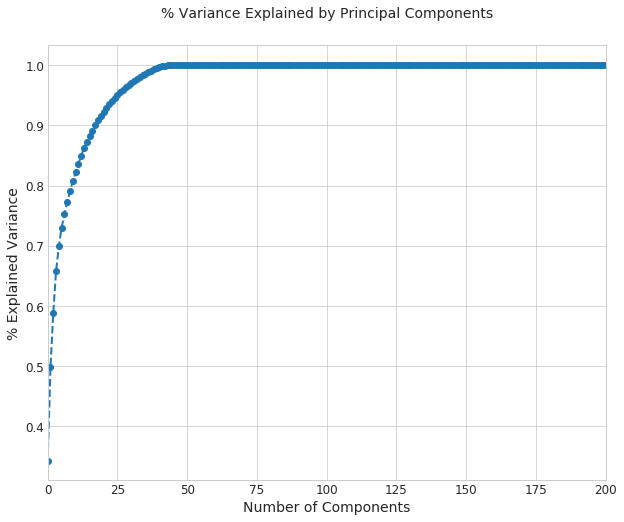

In [72]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [75]:
pca=PCA(n_components=45,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 45 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 45 components is: 0.999897296561


In [76]:
print("The train/test split ratio is 80:20")
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_pca_21,y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [77]:
## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [78]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,45).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.870850861301
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27587   218    27805
True        3988   774     4762
__all__    31575   992    32567

Accuracy of the KNN model for twst data is: 0.865880619013
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6897    76     6973
True        1016   153     1169
__all__     7913   229     8142



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.884177234624
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24978  2827    27805
True         945  3817     4762
__all__    25923  6644    32567

Accuracy of the Logistic Regression model for twst data is: 0.882952591501
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6247   726     6973
True         227   942     1169
__all__     6474  1668     8142



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.914422574999
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25188  2617    27805
True         170  4592     4762
__all__    25358  7209    32567

Accuracy of the Random Forest Classifier for twst data is: 0.899778924097
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6292   681     6973
True         135  1034     1169
__all__     6427  1715     8142



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.891608069518
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25029  2776    27805
True         754  4008     4762
__all__    25783  6784    32567

Accuracy of the Ada Boost Classifier for twst data is: 0.888111029231
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6255   718     6973
True         193   976     1169
__all__     6448  1694     8142



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.901219025394
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25209  2596    27805
True         621  4141     4762
__all__    25830  6737    32567

Accuracy of the Gradient Boosting Classifier for twst data is: 0.893760746745
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6289   684     6973
True         181   988     1169
__all__     6470  1672     8142



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.91663340191
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25202  2603    27805
True         112  4650     4762
__all__    25314  7253    32567

Accuracy of the Extra Tree Classifier for twst data is: 0.900393023827
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6293   680     6973
True         131  1038     1169
__all__     6424  1718     8142



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.914545398716
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      25186  2619    27805
True         164  4598     4762
__all__    25350  7217    32567

Accuracy of the Bagging model for twst data is: 0.898427904692
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6274   699     6973
True         128  1041     1169
__all__     6402  1740     8142



Neural Network-1
The accuracy of the model on training data is: 0.907882212035


Predicted  False  True  __all__
Actual                         
False      25038  2767    27805
True         233  4529     4762
__all__    25271  7296    32567

The accuracy of the model on test data is: 0.89302382707


Predicted  False  True  __all__
Actual                         
False       6228   745     6973
True         126  1043     1169
__all__     6354  1788     8142

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [79]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [80]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.870851,774.0,27587.0,218.0,3988.0,0.007840,0.837463
LogisticRegression,0.884177,3817.0,24978.0,2827.0,945.0,0.101672,0.198446
RandomForestClassifier,0.914423,4592.0,25188.0,2617.0,170.0,0.094120,0.035699
AdaBoostClassifier,0.891608,4008.0,25029.0,2776.0,754.0,0.099838,0.158337
GradientBoostingClassifier,0.901219,4141.0,25209.0,2596.0,621.0,0.093365,0.130407
ExtraTreeClassifier,0.916633,4650.0,25202.0,2603.0,112.0,0.093616,0.023520
BaggingClassifier,0.914545,4598.0,25186.0,2619.0,164.0,0.094192,0.034439
Neural Network-1,0.907882,4529.0,25038.0,2767.0,233.0,0.099514,0.048929


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.865881,153.0,6897.0,76.0,1016.0,0.010899,0.869119,0.559991
LogisticRegression,0.882953,942.0,6247.0,726.0,227.0,0.104116,0.194183,0.850851
RandomForestClassifier,0.899779,1034.0,6292.0,681.0,135.0,0.097662,0.115483,0.893427
AdaBoostClassifier,0.888111,976.0,6255.0,718.0,193.0,0.102969,0.165098,0.865967
GradientBoostingClassifier,0.893761,988.0,6289.0,684.0,181.0,0.098093,0.154833,0.873537
ExtraTreeClassifier,0.900393,1038.0,6293.0,680.0,131.0,0.097519,0.112062,0.895210
BaggingClassifier,0.898428,1041.0,6274.0,699.0,128.0,0.100244,0.109495,0.895130
Neural Network-1,0.893024,1043.0,6228.0,745.0,126.0,0.106841,0.107784,0.895130


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [81]:
feat_impt_plot(np.average(feat_imp,axis=0),np.arange(0,45).astype(str))

### <a id='4' style="text-decoration : none; color : #000000;"> 5. Over Sampling</a>

In [94]:
columns=fin_col
print("Features we will be using:")
display(columns)

Features we will be using:


['number_of_cookies',
 'number_of_unsecure_cookies',
 'number_of_non_http_only_cookies',
 'dom_function_document.getElementsByTagName(',
 'number_of_http_only_cookies',
 'dom_function_document.createElement(',
 'js_function_.getTime(',
 'dom_function_window.addEventListener(',
 'number_of_secure_cookies',
 'js_function_.split(',
 'js_function_Math.random(',
 'js_function_.setTime(',
 'js_function_.replace(',
 'js_function_.indexOf(',
 'js_function_Math.floor(',
 'js_function_decodeURIComponent(',
 'js_function_.match(',
 'js_function_JSON.parse(',
 'js_function_.pop(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_encodeURIComponent(',
 'js_function_.test(',
 'js_function_.apply(',
 'js_function_.substr',
 'script_src_.js',
 'script_count',
 'script_src_relative',
 'script_src_absolute',
 'script_src_https',
 'script_async_true',
 'link_rel_canonical',
 'div_count',
 'script_type_text/javascript',
 'script_src_out_of_domain',
 'iframe_count',
 'a_count',
 'a_href_rela

In [95]:
### Preparing our training and test sets
X=df[columns].values
y=df.Target.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(X_train, Y_train)

The train/test split ratio is 80:20


In [96]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [97]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.930389060369
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24500   3362    27862
True         517  27345    27862
__all__    25017  30707    55724

Accuracy of the KNN model for twst data is: 0.875460574797
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5991   925     6916
True          89  1137     1226
__all__     6080  2062     8142



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.881469384825
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      22725   5137    27862
True        1468  26394    27862
__all__    24193  31531    55724

Accuracy of the Logistic Regression model for twst data is: 0.83738639155
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5665  1251     6916
True          73  1153     1226
__all__     5738  2404     8142



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.947365587539
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25060   2802    27862
True         131  27731    27862
__all__    25191  30533    55724

Accuracy of the Random Forest Classifier for twst data is: 0.899901744043
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6190   726     6916
True          89  1137     1226
__all__     6279  1863     8142



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.896095039839
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23695   4167    27862
True        1623  26239    27862
__all__    25318  30406    55724

Accuracy of the Ada Boost Classifier for twst data is: 0.868337017932
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5925   991     6916
True          81  1145     1226
__all__     6006  2136     8142



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.923767138037
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24314   3548    27862
True         700  27162    27862
__all__    25014  30710    55724

Accuracy of the Gradient Boosting Classifier for twst data is: 0.881970031933
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6032   884     6916
True          77  1149     1226
__all__     6109  2033     8142



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.948119302276
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25069   2793    27862
True          98  27764    27862
__all__    25167  30557    55724

Accuracy of the Extra Tree Classifier for twst data is: 0.900024563989
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6198   718     6916
True          96  1130     1226
__all__     6294  1848     8142



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.947222022827
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      25057   2805    27862
True         136  27726    27862
__all__    25193  30531    55724

Accuracy of the Bagging model for twst data is: 0.8981822648
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6171   745     6916
True          84  1142     1226
__all__     6255  1887     8142



Neural Network-1
The accuracy of the model on training data is: 0.935718900294


Predicted  False   True  __all__
Actual                          
False      24525   3337    27862
True         245  27617    27862
__all__    24770  30954    55724

The accuracy of the model on test data is: 0.884303610906


Predicted  False  True  __all__
Actual                         
False       6048   868     6916
True          74  1152     1226
__all__     6122  2020     8142

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [98]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [99]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.930389,27345.0,24500.0,3362.0,517.0,0.120666,0.018556
LogisticRegression,0.881469,26394.0,22725.0,5137.0,1468.0,0.184373,0.052688
RandomForestClassifier,0.947366,27731.0,25060.0,2802.0,131.0,0.100567,0.004702
AdaBoostClassifier,0.896095,26239.0,23695.0,4167.0,1623.0,0.149559,0.058251
GradientBoostingClassifier,0.923767,27162.0,24314.0,3548.0,700.0,0.127342,0.025124
ExtraTreeClassifier,0.948119,27764.0,25069.0,2793.0,98.0,0.100244,0.003517
BaggingClassifier,0.947222,27726.0,25057.0,2805.0,136.0,0.100675,0.004881
Neural Network-1,0.935719,27617.0,24525.0,3337.0,245.0,0.119769,0.008793


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.875461,1137.0,5991.0,925.0,89.0,0.133748,0.072594,0.896829
LogisticRegression,0.837386,1153.0,5665.0,1251.0,73.0,0.180885,0.059543,0.879786
RandomForestClassifier,0.899902,1137.0,6190.0,726.0,89.0,0.104974,0.072594,0.911216
AdaBoostClassifier,0.868337,1145.0,5925.0,991.0,81.0,0.143291,0.066069,0.895320
GradientBoostingClassifier,0.881970,1149.0,6032.0,884.0,77.0,0.127820,0.062806,0.904687
ExtraTreeClassifier,0.900025,1130.0,6198.0,718.0,96.0,0.103817,0.078303,0.908940
BaggingClassifier,0.898182,1142.0,6171.0,745.0,84.0,0.107721,0.068515,0.911882
Neural Network-1,0.884304,1152.0,6048.0,868.0,74.0,0.125506,0.060359,0.911882


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [100]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='5' style="text-decoration : none; color : #000000;"> 6. Under Sampling</a>

In [101]:
df_non=df[df.Target==0]
df_mal=df[df.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X=df_u[columns]
y=df_u.Target.values

feature_name = X.columns.tolist()
print("Shape after undersampling",df_u.shape)
df_u.head()

Shape after undersampling (11862, 224)


,dom_function_document.createElement(,dom_function_document.getElementById(,dom_function_document.getElementsByTagName(,dom_function_document.querySelector(,dom_function_document.write(,dom_function_window.addEventListener(,dom_function_window.open(,dom_function_window.setTimeout(,js_function_.add(,js_function_.apply(,js_function_.bind(,js_function_.call(,js_function_.charAt(,js_function_.concat(,js_function_.defineProperty(,js_function_.exec(,js_function_.find(,js_function_.forEach(,js_function_.get(,js_function_.getTime(,js_function_.hasOwnProperty(,js_function_.indexOf(,js_function_.join(,js_function_.keys(,js_function_.log(,js_function_.match(,js_function_.pop(,js_function_.push(,js_function_.replace(,js_function_.setTime(,js_function_.shift(,js_function_.slice(,js_function_.split(,js_function_.substr,js_function_.substring(,js_function_.test(,js_function_.toLowerCase(,js_function_.toString(,js_function_.trim(,js_function_JSON.parse(,js_function_JSON.stringify(,js_function_Math.floor(,js_function_Math.max(,js_function_Math.random(,js_function_Math.round(,js_function_Object.defineProperty(,js_function_Object.keys(,js_function_decodeURIComponent(,js_function_encodeURIComponent(,js_function_escape(,js_function_isNaN(,js_function_parseInt(,js_function_unescape(,number_of_cookies,number_of_http_only_cookies,number_of_non_http_only_cookies,number_of_secure_cookies,number_of_unsecure_cookies,Target_x,a_count,a_href_.aspx,a_href_.com,a_href_.htm,a_href_.html,a_href_.pdf,a_href_.php,a_href_0,a_href_absolute,a_href_http,a_href_https,a_href_mailto,a_href_out_of_domain,a_href_relative,a_href_script_javascript,a_rel_nofollow,article_count,aside_count,b_count,base_count,base_href_absolute,base_href_out_of_domain,base_href_relative,br_count,button_count,center_count,dd_count,div_count,dl_count,dt_count,em_count,fieldset_count,figure_count,font_count,footer_count,form_action_.php,form_action_absolute,form_action_http,form_action_https,form_action_out_of_domain,form_action_relative,form_count,form_enctype_application/x-www-form-urlencoded,h1_count,header_count,hr_count,i_count,iframe_count,iframe_sandbox_allow_same_origin_count,iframe_sandbox_allow_scripts_count,iframe_src_.com,iframe_src_.html,iframe_src_0,iframe_src_absolute,iframe_src_http,iframe_src_https,iframe_src_out_of_domain,iframe_src_relative,img_count,img_src_.gif,img_src_.jpeg,img_src_.jpg,img_src_.png,img_src_.svg,img_src_0,img_src_absolute,img_src_http,img_src_https,img_src_out_of_domain,img_src_relative,img_srcset_absolute,img_srcset_https,img_srcset_out_of_domain,img_srcset_relative,input_count,ins_count,label_count,li_count,link_count,link_href_.com,link_href_.css,link_href_.ico,link_href_.json,link_href_.php,link_href_.png,link_href_.xml,link_href_0,link_href_absolute,link_href_http,link_href_https,link_href_out_of_domain,link_href_relative,link_rel_EditURI,link_rel_alternate,link_rel_apple-touch-icon,link_rel_apple-touch-icon-precomposed,link_rel_canonical,link_rel_dns-prefetch,link_rel_https://api.w.org/,link_rel_icon,link_rel_manifest,link_rel_next,link_rel_pingback,link_rel_preload,link_rel_profile,link_rel_publisher,link_rel_shortcut icon,link_rel_shortlink,link_rel_stylesheet,link_rel_wlwmanifest,link_type_application/rsd+xml,link_type_application/rss+xml,link_type_application/wlwmanifest+xml,link_type_image/png,link_type_image/x-icon,link_type_text/css,main_count,meta_charset_UTF-8,meta_charset_utf-8,meta_count,meta_http-equiv_Content-Type,meta_http-equiv_X-UA-Compatible,meta_http-equiv_content-type,nav_count,nofollow_count,noopener_count,noscript_count,ol_count,option_count,p_count,script_async_true,script_charset_UTF-8,script_charset_utf-8,script_count,script_crossorigin_anonymous,script_defer_true,script_language_JavaScript,script_language_javascript,script_src_.com,script_src_.js,script_src_0,script_src_absolute,script_src_http,script_src_https,script_src_out_of_domain,script_src_relative,script_type_application/ld+json,script_type_text/javascript,section_coun

In [102]:
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)


The train/test split ratio is 80:20


In [103]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [105]:
print('Features we will be using:\n')
display(columns)

Features we will be using:



['number_of_cookies',
 'number_of_unsecure_cookies',
 'number_of_non_http_only_cookies',
 'dom_function_document.getElementsByTagName(',
 'number_of_http_only_cookies',
 'dom_function_document.createElement(',
 'js_function_.getTime(',
 'dom_function_window.addEventListener(',
 'number_of_secure_cookies',
 'js_function_.split(',
 'js_function_Math.random(',
 'js_function_.setTime(',
 'js_function_.replace(',
 'js_function_.indexOf(',
 'js_function_Math.floor(',
 'js_function_decodeURIComponent(',
 'js_function_.match(',
 'js_function_JSON.parse(',
 'js_function_.pop(',
 'js_function_.charAt(',
 'js_function_.concat(',
 'js_function_encodeURIComponent(',
 'js_function_.test(',
 'js_function_.apply(',
 'js_function_.substr',
 'script_src_.js',
 'script_count',
 'script_src_relative',
 'script_src_absolute',
 'script_src_https',
 'script_async_true',
 'link_rel_canonical',
 'div_count',
 'script_type_text/javascript',
 'script_src_out_of_domain',
 'iframe_count',
 'a_count',
 'a_href_rela

In [106]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j]=f[i](X_train,Y_train,X_test,Y_test,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc])
    print("\n")

K-Nearest Neighbors
Accuracy of the KNN model for training data is: 0.911476446412
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4165   607     4772
True         233  4484     4717
__all__     4398  5091     9489

Accuracy of the KNN model for twst data is: 0.887062789718
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        971   188     1159
True          80  1134     1214
__all__     1051  1322     2373



Logistic Regression
Accuracy of the Logistic Regression model for training data is: 0.879755506376
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3899   873     4772
True         268  4449     4717
__all__     4167  5322     9489

Accuracy of the Logistic Regression model for twst data is: 0.865571007164
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        927   232     1159
True          87  1127     1214
__all__     1014  1359     2373



RandomForest Classifier
Accuracy of the Random Forest Classifier model for training data is: 0.945199704921
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4303   469     4772
True          51  4666     4717
__all__     4354  5135     9489

Accuracy of the Random Forest Classifier for twst data is: 0.900969237252
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        991   168     1159
True          67  1147     1214
__all__     1058  1315     2373



Adaoost Classifier
Accuracy of the Ada Boost Classifier model for training data is: 0.896722520814
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4071   701     4772
True         279  4438     4717
__all__     4350  5139     9489

Accuracy of the Ada Boost Classifier for twst data is: 0.877791824694
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        959   200     1159
True          90  1124     1214
__all__     1049  1324     2373



GradientBoosting Classifier
Accuracy of the Gradient Boosting Classifier model for training data is: 0.913478764886
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4145   627     4772
True         194  4523     4717
__all__     4339  5150     9489

Accuracy of the Gradient Boosting Classifier for twst data is: 0.894648124737
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        972   187     1159
True          63  1151     1214
__all__     1035  1338     2373



ExtraTree Classifier
Accuracy of the Extra Tree Classifier model for training data is: 0.94920434187
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4312   460     4772
True          22  4695     4717
__all__     4334  5155     9489

Accuracy of the Extra Tree Classifier for twst data is: 0.895069532238
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        998   161     1159
True          88  1126     1214
__all__     1086  1287     2373



Bagging Classifier
Accuracy of the Bagging model for training data is: 0.946358941933
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4311   461     4772
True          48  4669     4717
__all__     4359  5130     9489

Accuracy of the Bagging model for twst data is: 0.898019384745
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        990   169     1159
True          73  1141     1214
__all__     1063  1310     2373



Neural Network-1
The accuracy of the model on training data is: 0.933185794096


Predicted  False  True  __all__
Actual                         
False       4191   581     4772
True          53  4664     4717
__all__     4244  5245     9489

The accuracy of the model on test data is: 0.889591234724


Predicted  False  True  __all__
Actual                         
False        956   203     1159
True          59  1155     1214
__all__     1015  1358     2373

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [107]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [108]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.911476,4484.0,4165.0,607.0,233.0,0.127200,0.049396
LogisticRegression,0.879756,4449.0,3899.0,873.0,268.0,0.182942,0.056816
RandomForestClassifier,0.945200,4666.0,4303.0,469.0,51.0,0.098282,0.010812
AdaBoostClassifier,0.896723,4438.0,4071.0,701.0,279.0,0.146899,0.059148
GradientBoostingClassifier,0.913479,4523.0,4145.0,627.0,194.0,0.131391,0.041128
ExtraTreeClassifier,0.949204,4695.0,4312.0,460.0,22.0,0.096396,0.004664
BaggingClassifier,0.946359,4669.0,4311.0,461.0,48.0,0.096605,0.010176
Neural Network-1,0.933186,4664.0,4191.0,581.0,53.0,0.121752,0.011236


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
KNeighborsClassifier,0.887063,1134.0,971.0,188.0,80.0,0.162209,0.065898,0.885947
LogisticRegression,0.865571,1127.0,927.0,232.0,87.0,0.200173,0.071664,0.864082
RandomForestClassifier,0.900969,1147.0,991.0,168.0,67.0,0.144953,0.055189,0.899929
AdaBoostClassifier,0.877792,1124.0,959.0,200.0,90.0,0.172563,0.074135,0.876651
GradientBoostingClassifier,0.894648,1151.0,972.0,187.0,63.0,0.161346,0.051895,0.893380
ExtraTreeClassifier,0.895070,1126.0,998.0,161.0,88.0,0.138913,0.072488,0.894300
BaggingClassifier,0.898019,1141.0,990.0,169.0,73.0,0.145815,0.060132,0.897026
Neural Network-1,0.889591,1155.0,956.0,203.0,59.0,0.175151,0.048600,0.897026


### <a id='5.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [109]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

In [110]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')